# Merge station data from the 4D var and verification runs

In [26]:
import dask
dask.config.set(scheduler='processes')


In [27]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
from scipy.interpolate import PchipInterpolator

from glob import glob
from matplotlib import rcParams
from sfoda.roms.romsio import  get_depth
from sfoda.utils.myproj import MyProj
from mycurrents import oceanmooring as om
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "12"
rcParams['axes.labelsize']='medium'

In [28]:
# !ls /scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/verification
# ! ls ../ROMSdata/SUNTANS_NESTING
! ls ../ROMSdata/4DVAR_STA/

sta_6241.nc  sta_6289.nc  sta_6337.nc	   sta_ver_6265.nc  sta_ver_6313.nc
sta_6245.nc  sta_6293.nc  sta_6341.nc	   sta_ver_6269.nc  sta_ver_6317.nc
sta_6249.nc  sta_6297.nc  sta_6345.nc	   sta_ver_6273.nc  sta_ver_6321.nc
sta_6253.nc  sta_6301.nc  sta_6349.nc	   sta_ver_6277.nc  sta_ver_6325.nc
sta_6257.nc  sta_6305.nc  sta_6353.nc	   sta_ver_6281.nc  sta_ver_6329.nc
sta_6261.nc  sta_6309.nc  sta_6357.nc	   sta_ver_6285.nc  sta_ver_6333.nc
sta_6265.nc  sta_6313.nc  sta_ver_6241.nc  sta_ver_6289.nc  sta_ver_6337.nc
sta_6269.nc  sta_6317.nc  sta_ver_6245.nc  sta_ver_6293.nc  sta_ver_6341.nc
sta_6273.nc  sta_6321.nc  sta_ver_6249.nc  sta_ver_6297.nc  sta_ver_6345.nc
sta_6277.nc  sta_6325.nc  sta_ver_6253.nc  sta_ver_6301.nc  sta_ver_6349.nc
sta_6281.nc  sta_6329.nc  sta_ver_6257.nc  sta_ver_6305.nc  sta_ver_6353.nc
sta_6285.nc  sta_6333.nc  sta_ver_6261.nc  sta_ver_6309.nc  sta_ver_6357.nc


In [29]:
# Load a ROMS timeseries object
def get_roms_station_da(romsfile, romsvar, xyin, cycle=0, ncycles=3):
    dsroms = xr.open_dataset(romsfile)
    #print(dsroms)
    zroms = get_depth(dsroms.s_rho.values, dsroms.Cs_r.values, dsroms.hc.values, dsroms.h.values)# , \
    #         Vtransform=dsroms.Vtransform.values)
    xroms = dsroms.lon_rho.values
    yroms = dsroms.lat_rho.values
    
    nt = dsroms.ocean_time.size//ncycles

    # Get the point
    dist = np.abs( (xyin[0]-xroms) + 1j*(xyin[1]-yroms))
    idx = np.argwhere(dist==dist.min())[0,0]
    #print(xyin, xroms[idx], yroms[idx], dist[idx], zroms[:,idx])
    #print(xyin[0], xroms[idx], xyin[1], yroms[idx], dist[idx])
    
    t0 = cycle*nt
    t1 = t0 + nt

    data = dsroms[romsvar][t0:t1,idx,:].values
    #print(zroms[...].shape, data.shape)
    #print(zroms.ravel())

    #Fi = interp1d(zroms[...,idx].squeeze(), data.squeeze(), axis=1, fill_value='extrapolate')
    
    #return om.OceanMooring(dsroms.ocean_time.values[t0:t1], Fi(zin), zin)
    return om.OceanMooring(dsroms.ocean_time.values[t0:t1], data.squeeze(), zroms[...,idx].squeeze())

def get_roms_station(romsfile, romsvar, xyin):
    dsroms = xr.open_dataset(romsfile)
    #print(dsroms)
    zroms = get_depth(dsroms.s_rho.values, dsroms.Cs_r.values, dsroms.hc.values, dsroms.h.values)# , \
    #         Vtransform=dsroms.Vtransform.values)
    xroms = dsroms.lon_rho.values
    yroms = dsroms.lat_rho.values

    # Get the point
    dist = np.abs( (xyin[0]-xroms) + 1j*(xyin[1]-yroms))
    idx = np.argwhere(dist==dist.min())[0,0]
    #print(xyin, xroms[idx], yroms[idx])

    data = dsroms[romsvar][:,idx,:]
    return om.OceanMooring(dsroms.ocean_time.values, data.squeeze(), zroms[...,idx].squeeze())
    #print(zroms[...].shape, data.shape)
    #print(zroms.ravel())
    
    #Fi = interp1d(zroms[...,idx].squeeze(), data.squeeze(), axis=1, fill_value='extrapolate')
    
    #return om.OceanMooring(dsroms.ocean_time.values, Fi(zin), zin)

In [35]:
# Add the site location
P = MyProj(None, utmzone=51,isnorth=False)

lon_prelude, lat_prelude = P.to_ll(534322.7, 8475878.4)

sites = pd.DataFrame(np.array([[lon_prelude, 123.3535, 123.2803, 123.346383,127.56335, 123.0459],\
            [lat_prelude, -13.7621, -13.8170, -13.75895, -9.8122, -14.2426]]).T,
            index=['Prelude','NP250','DWR','KP150_phs2','ITFTIS','BRB200'], columns=['lon','lat'])


In [31]:
# romsdir= '/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/'
romsdir = '../ROMSdata/4DVAR_STA/'
roms4dvarfiles = sorted(glob('{}/sta_6*.nc'.format(romsdir)))
romsfiles = sorted(glob('{}/sta_ver_6*.nc'.format(romsdir)))

In [32]:
romsfiles[0:2],roms4dvarfiles[0:2]

(['../ROMSdata/4DVAR_STA/sta_ver_6241.nc',
  '../ROMSdata/4DVAR_STA/sta_ver_6245.nc'],
 ['../ROMSdata/4DVAR_STA/sta_6241.nc', '../ROMSdata/4DVAR_STA/sta_6245.nc'])

In [33]:
def load_station(loadfunc, roms4dvarfiles, sitename, varname):
    xyin = [sites['lon'][sitename],sites['lat'][sitename] ]

    ds = loadfunc(roms4dvarfiles[0], varname, xyin)
    for ff in roms4dvarfiles[1:]:
        ds = ds.concat(loadfunc(ff, varname, xyin))

    #ds.long_name = 'Water Temperature'
    #ds.units = 'degrees C'
    ds.X = xyin[0]
    ds.Y = xyin[1]
    ds.StationName = sitename
    return ds.to_xray()

In [22]:
sitename = 'NP250'
outfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
T = load_station(get_roms_station_da, roms4dvarfiles, sitename,'temp')
u = load_station(get_roms_station_da, roms4dvarfiles, sitename,'u_eastward')
v = load_station(get_roms_station_da, roms4dvarfiles, sitename,'v_northward')
xr.Dataset({'temp':T,'u_eastward':u,'v_northward':v}).to_netcdf(outfile)
print(outfile)

outfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)
T = load_station(get_roms_station, romsfiles, sitename,'temp')
u = load_station(get_roms_station, romsfiles, sitename,'u_eastward')
v = load_station(get_roms_station, romsfiles, sitename,'v_northward')
xr.Dataset({'temp':T,'u_eastward':u,'v_northward':v}).to_netcdf(outfile)
print(outfile)

../DATA/ROMS_4DVAR_station_NP250_v3.nc
../DATA/ROMS_NL_station_NP250_v3.nc


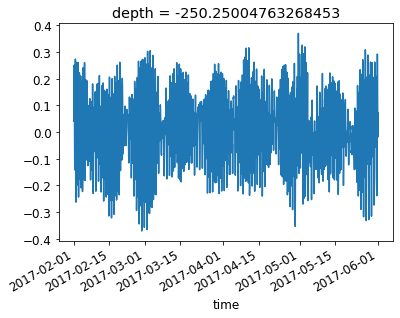

In [23]:
# Check the nonlinear data
plt.figure()
u[0,:].plot()

In [24]:
sitename = 'ITFTIS'
outfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
T = load_station(get_roms_station_da, roms4dvarfiles, sitename,'temp')
u = load_station(get_roms_station_da, roms4dvarfiles, sitename,'u_eastward')
v = load_station(get_roms_station_da, roms4dvarfiles, sitename,'v_northward')
xr.Dataset({'temp':T,'u_eastward':u,'v_northward':v}).to_netcdf(outfile)
print(outfile)

outfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)
T = load_station(get_roms_station, romsfiles, sitename,'temp')
u = load_station(get_roms_station, romsfiles, sitename,'u_eastward')
v = load_station(get_roms_station, romsfiles, sitename,'v_northward')
xr.Dataset({'temp':T,'u_eastward':u,'v_northward':v}).to_netcdf(outfile)
print(outfile)

../DATA/ROMS_4DVAR_station_ITFTIS_v3.nc
../DATA/ROMS_NL_station_ITFTIS_v3.nc


In [25]:
sitename = 'BRB200'
outfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
T = load_station(get_roms_station_da, roms4dvarfiles, sitename,'temp')
u = load_station(get_roms_station_da, roms4dvarfiles, sitename,'u_eastward')
v = load_station(get_roms_station_da, roms4dvarfiles, sitename,'v_northward')
xr.Dataset({'temp':T,'u_eastward':u,'v_northward':v}).to_netcdf(outfile)
print(outfile)

outfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)
T = load_station(get_roms_station, romsfiles, sitename,'temp')
u = load_station(get_roms_station, romsfiles, sitename,'u_eastward')
v = load_station(get_roms_station, romsfiles, sitename,'v_northward')
xr.Dataset({'temp':T,'u_eastward':u,'v_northward':v}).to_netcdf(outfile)
print(outfile)

../DATA/ROMS_4DVAR_station_BRB200_v3.nc
../DATA/ROMS_NL_station_BRB200_v3.nc
